<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_10_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is Cross-Validation?

**Cross-validation** is a statistical method used to evaluate the performance of a machine learning model. It involves splitting the dataset into multiple subsets, training the model on some of these subsets, and testing it on the remaining subsets. This process is repeated multiple times to ensure the model's performance is consistent and not dependent on any specific subset of data.

### How Cross-Validation Works

1. **Split the Data**: The dataset is divided into k subsets (or folds).
2. **Train and Test**: For each fold:
   - Train the model on k-1 folds.
   - Test the model on the remaining fold.
3. **Repeat**: This process is repeated k times, each time using a different fold as the test set.
4. **Aggregate Results**: The performance metrics from each iteration are averaged to produce a single estimation of the model's performance.

### Why Use Cross-Validation?

- **Robust Evaluation**: It provides a more reliable estimate of the model's performance by reducing the impact of the specific train-test split.
- **Prevents Overfitting**: Helps to detect if the model is overfitting to a specific subset of the data.
- **Optimizes Model Selection**: Allows comparison of different models or hyperparameters in a consistent manner.

### Why Use F1-Macro as the Scoring Metric?

**F1-Macro** is the harmonic mean of precision and recall, calculated for each class individually and then averaged. This is particularly useful when dealing with imbalanced datasets.

#### Reasons for Choosing F1-Macro:

1. **Imbalanced Classes**: In cases like loan default prediction, where one class (e.g., defaults) is much less frequent than the other, F1-macro provides a better measure of the model's performance across all classes.
2. **Focus on Minority Class**: While metrics like accuracy can be misleading in imbalanced datasets, F1-macro ensures that both precision and recall are considered, giving a more balanced view of performance.
3. **Overall Performance**: Macro-averaging ensures that the performance of each class is equally important, which is crucial for understanding how well the model performs across different classes.

### Brief Explanation in the Context of Your Project

1. **Cross-Validation**:
   - **Implementation**: By using k-fold cross-validation (e.g., 5-fold), you ensure that the model is evaluated on different subsets of data, providing a robust estimate of its performance.
   - **Benefit**: This helps in understanding how well the model generalizes to unseen data, ensuring that the results are not biased by any specific train-test split.

2. **F1-Macro**:
   - **Reason for Choice**: Since your primary concern is to accurately predict loan defaults (a minority class), using F1-macro ensures that both precision and recall for each class are considered.
   - **Impact**: This metric helps in achieving a balance between identifying as many defaults as possible (recall) and minimizing false positives (precision), providing a comprehensive view of the model's performance.

### Summary

- **Cross-Validation**: A robust method to evaluate model performance by splitting data into multiple folds and averaging results.
- **F1-Macro**: A suitable metric for imbalanced datasets, focusing on balanced performance across all classes.

By understanding and implementing these techniques, you ensure a more reliable and fair evaluation of your machine learning model.

### Load and Preprocess the Data

In [11]:
# Import necessary libraries
import importlib
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom modules
from model_pipeline import (
    load_data_from_url, load_and_preprocess_data, apply_feature_engineering,
    clean_column_names, rename_columns, remove_id_column,
    convert_categorical, split_data, define_preprocessor, preprocess_data,
    calculate_class_weights, convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns
)
from resampling_utils import (
    run_resampling_pipeline, reports_to_dataframe, apply_feature_set, plot_metric
)
from model_evaluation import evaluate_class_weights, class_weights_to_dataframe

# Define Global Parameters
best_class_weight = 3.0
best_lower_threshold = 0.40

# Load and Preprocess Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
target = 'default_payment_next_month'  # Specify your target column

data, target = load_and_preprocess_data(url, categorical_columns, target)

# Apply feature engineering
data = apply_feature_engineering(data)

# Split the data
X_train, X_test, y_train, y_test = split_data(data, target=target)


### Define the Cross-Validation Process

In [12]:
# Convert data to tensors for cross-validation
preprocessor = define_preprocessor(X_train)
X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
    X_train_processed, y_train, X_test_processed, y_test)

# Define the neural network estimator with the best parameters
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_class_weight, threshold=best_lower_threshold)

# Perform cross-validation
scores = cross_val_score(nn_estimator, X_train_tensor.numpy(), y_train_tensor.numpy(), cv=5, scoring='f1_macro')
print("Cross-Validation F1 Macro Scores:", scores)
print("Mean F1 Macro Score:", np.mean(scores))

Cross-Validation F1 Macro Scores: [0.63489542 0.65980673 0.61947646 0.6395864  0.64863301]
Mean F1 Macro Score: 0.6404796056075229


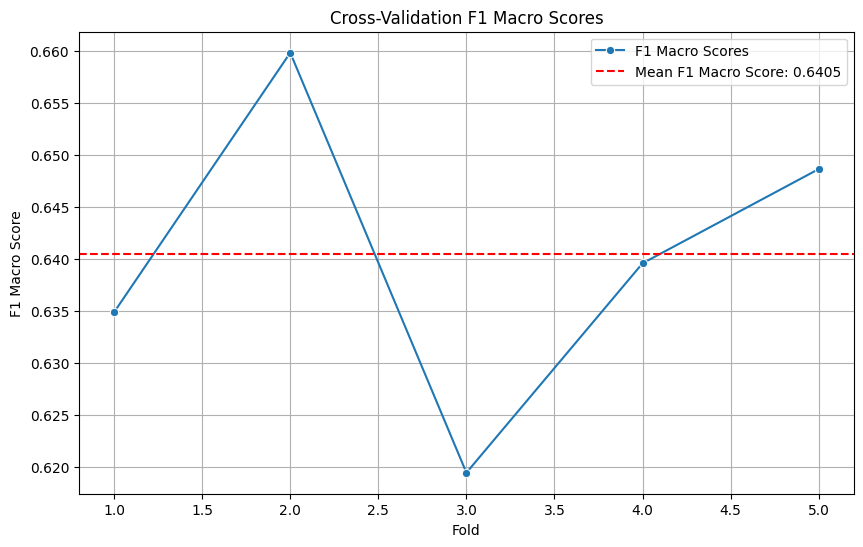

In [13]:
# Plot the cross-validation scores
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(1, len(scores) + 1), y=scores, marker='o', label='F1 Macro Scores')
plt.axhline(np.mean(scores), linestyle='--', color='red', label=f'Mean F1 Macro Score: {np.mean(scores):.4f}')
plt.xlabel('Fold')
plt.ylabel('F1 Macro Score')
plt.title('Cross-Validation F1 Macro Scores')
plt.legend()
plt.grid(True)
plt.show()


### Analysis of Results

### Interpretation of Cross-Validation Results

The cross-validation results provide insight into the model's performance consistency across different subsets of the data. Here's a detailed interpretation of the results:

#### Cross-Validation F1 Macro Scores

- **Scores**:
  - Fold 1: 0.6349
  - Fold 2: 0.6598
  - Fold 3: 0.6195
  - Fold 4: 0.6396
  - Fold 5: 0.6486

- **Mean F1 Macro Score**: 0.6405

### Detailed Interpretation

1. **Consistency**:
   - The F1 macro scores across the 5 folds range from approximately 0.6195 to 0.6598. This range indicates some variation in model performance across different subsets of the data.
   - The variation is relatively small (within 0.0403), suggesting that the model's performance is fairly consistent across different folds.

2. **Mean F1 Macro Score**:
   - The mean F1 macro score of 0.6405 indicates the overall performance of the model when considering both precision and recall for both classes (default and non-default).
   - This score provides a balanced measure of the model's ability to correctly classify both classes, considering the imbalanced nature of the dataset.

3. **Performance Across Folds**:
   - The highest F1 macro score is 0.6598 (Fold 2), and the lowest is 0.6195 (Fold 3). This suggests that the model performs slightly better on some subsets of the data than others.
   - The scores are reasonably close to each other, indicating that the model is not significantly overfitting to any particular fold.

### Implications for the Model

- **Model Reliability**:
  - The relatively consistent F1 macro scores across the folds suggest that the model is reliable and generalizes well to different subsets of the data.
  
- **Areas for Improvement**:
  - While the scores are consistent, there is still room for improvement. Exploring additional feature engineering, hyperparameter tuning, or trying different model architectures could help enhance the performance further.
  
- **Deployment Readiness**:
  - Given the consistency in performance, the model appears to be in a good state for further evaluation and potential deployment. However, additional validation on a holdout test set or through other validation techniques would provide further confidence.

### Summary

- **Consistency**: The model shows fairly consistent performance across the different folds of cross-validation.
- **Mean Performance**: The mean F1 macro score of 0.6405 indicates a balanced performance in terms of precision and recall for both classes.
- **Next Steps**: Further improvements can be explored through additional tuning and validation, but the current results are promising for a reliable model.

By understanding these results, you can make informed decisions about the next steps in your model development and deployment process.

#### Write Model Evaluation Script

In [5]:
# function to write script
script_content = """
import pandas as pd
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from imblearn.pipeline import Pipeline as ImbPipeline

def evaluate_thresholds(data, target, thresholds, resampling_method=None, pos_weight=1.0):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for threshold in thresholds:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Threshold {threshold}")
        results.append({'threshold': threshold, 'report': report})

    return results

def thresholds_to_dataframe(results):
    data = []
    for result in results:
        threshold = result['threshold']
        report = result['report']
        flattened_report = {'threshold': threshold}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def evaluate_class_weights(data, target, class_weights, threshold=0.5, resampling_method=None):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for weight in class_weights:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Class Weight {weight}")
        results.append({'class_weight': weight, 'report': report})

    return results

def class_weights_to_dataframe(results):
    data = []
    for result in results:
        class_weight = result['class_weight']
        report = result['report']
        flattened_report = {'class_weight': class_weight}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

"""

# Write the script to a file
with open("model_evaluation.py", "w") as file:
    file.write(script_content)

print("Script successfully written to model_evaluation.py")

Script successfully written to model_evaluation.py


#### Write Resampling Script

In [6]:
# Function to write script
script_content = """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns
)

def run_resampling_pipeline(data, target, resampling_method=None, pos_weight=1.0, threshold=0.5):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=str(resampling_method))
    return report

# Convert reports to DataFrame for analysis
def reports_to_dataframe(reports):
    data = []
    for method, report in reports.items():
        flattened_report = {'method': method}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def apply_feature_set(data, feature_set):
    if 'bill_to_limit_ratios' in feature_set:
        data = create_bill_to_limit_ratios(data)
    if 'pay_to_limit_ratios' in feature_set:
        data = create_payment_to_limit_ratios(data)
    if 'payment_timeliness_features' in feature_set:
        data = create_payment_timeliness_features(data)
    if 'lagged_payment_differences' in feature_set:
        data = create_lagged_payment_differences(data)
    return data

def plot_metric(df, metric, title, ylabel):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='method', y=metric, hue='feature_set', data=df, palette='viridis')
    plt.title(title)
    plt.xlabel('Resampling Method')
    plt.ylabel(ylabel)
    plt.legend(title='Feature Set')
    plt.xticks(rotation=45)
    plt.show()

"""

# Write the functions to feature_engineering.py script
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to resampling_utils.py")

# reload script to make function available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

Functions successfully written to resampling_utils.py


<module 'resampling_utils' from '/content/resampling_utils.py'>

#### Write Pipeline Script

In [7]:
script_content = """

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import logging

from feature_engineering import (
    create_bill_to_limit_ratios, create_payment_to_limit_ratios,
    create_payment_timeliness_features, create_lagged_payment_differences
)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the dataset from a URL
def load_data_from_url(url):
    df = pd.read_excel(url, header=1)
    return df

# Clean column names
def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Define the preprocessor
def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor

# Preprocess the data
def preprocess_data(preprocessor, X_train, X_test):
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

# Calculate class weights for imbalanced datasets
def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

# Convert data to PyTorch tensors
def convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test):
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
                 pos_weight=1.0, threshold=0.5):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.threshold = threshold
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32)
            elif isinstance(X, pd.DataFrame):
                X = torch.tensor(X.values, dtype=torch.float32)
            outputs = self.model(X)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > self.threshold).float()
        return predictions.numpy().squeeze()

# Load and Preprocess Data
def load_and_preprocess_data(url, categorical_columns, target):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    return data, target

# apply feature engineering
def apply_feature_engineering(data):
    data = create_bill_to_limit_ratios(data)
    data = create_payment_to_limit_ratios(data)
    data = create_payment_timeliness_features(data)
    data = create_lagged_payment_differences(data)
    return data

# Train the Model
def train_model(nn_estimator, X_train_tensor, y_train_tensor):
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())
    return nn_estimator

# Evaluate the Model
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=""):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Function to run the full pipeline with resampling
def run_full_pipeline_with_resampling(url, categorical_columns, target, resampling_method=None):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    class_weights = calculate_class_weights(y_train)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Run full pipeline with resampling")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")
    parser.add_argument("--resampling", type=str, choices=['smote', 'oversample', 'undersample'], help="Resampling method")

    args = parser.parse_args()

    if args.resampling == 'smote':
        resampling_method = SMOTE(random_state=42)
    elif args.resampling == 'oversample':
        resampling_method = RandomOverSampler(random_state=42)
    elif args.resampling == 'undersample':
        resampling_method = RandomUnderSampler(random_state=42)
    else:
        resampling_method = None

    run_full_pipeline_with_resampling(args.url, args.categorical_columns, args.target, resampling_method)


"""

# Write the functions to model_pipeline.py script
with open("model_pipeline.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to model_pipeline.py")

# reload script to make function available for use
import importlib
import model_pipeline
importlib.reload(model_pipeline)


Functions successfully written to model_pipeline.py


<module 'model_pipeline' from '/content/model_pipeline.py'>

#### Write Feature Engineering Script

In [8]:
script_content = """
import pandas as pd
import numpy as np
import torch
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, train_model, calculate_class_weights, convert_to_tensors, preprocess_data, define_preprocessor, SimpleNN, SklearnSimpleNN
import matplotlib.pyplot as plt

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Apply feature engineering to the entire dataset
def create_interaction_features(df):
    df['limit_bal_age'] = df['limit_bal'] * df['age']
    return df

def target_encode(df, target, categorical_columns):
    for col in categorical_columns:
        mean_target = df.groupby(col)[target].mean()
        df[col + '_target_enc'] = df[col].map(mean_target)
    return df

def bin_features(df, column, bins):
    df[column + '_binned'] = pd.cut(df[column], bins=bins)
    return df

def create_payment_to_bill_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_bill_ratio_{i}'] = df[f'pay_amt{i}'] / df[f'bill_amt{i}'].replace(0, np.nan)
    return df

def create_payment_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_limit_ratio_{i}'] = df[f'pay_amt{i}'] / df['limit_bal']
    return df

def create_bill_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'bill_to_limit_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_lagged_payment_differences(df):
    for i in range(1, 6):
        df[f'pay_amt_diff_{i}'] = df[f'pay_amt{i+1}'] - df[f'pay_amt{i}']
    return df

def create_debt_ratio_features(df):
    for i in range(1, 7):
        df[f'debt_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_average_payment_and_bill(df):
    df['avg_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
    df['avg_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
    return df

def create_payment_timeliness_features(df):
    for i in range(1, 7):
        df[f'pay_on_time_{i}'] = (df[f'pay_{i}'] <= 0).astype(int)
    return df

def create_total_payment_and_bill(df):
    df['total_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)
    df['total_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
    return df

def create_bill_difference_features(df):
    for i in range(1, 6):
        df[f'bill_diff_{i}'] = df[f'bill_amt{i+1}'] - df[f'bill_amt{i}']
    return df

# Evaluate the model and save the report before feature engineering
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Incrementally Add Features and Evaluate
def add_features_incrementally(data, features_to_add, target, pos_weight, threshold):
    results = []

    for feature in features_to_add:
        # Create a copy of the data to avoid modifying the original DataFrame
        data_copy = data.copy()

        # Apply the feature engineering function
        print(f"Adding feature: {feature['name']}")
        data_copy = feature['func'](data_copy)

        # Split the data
        X_train, X_test, y_train, y_test = split_data(data_copy, target=target)

        # Preprocess the data
        preprocessor = define_preprocessor(X_train)
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

        # Convert data to tensors
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test)

        # Train the model
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

        # Evaluate the model
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=feature['name'])
        results.append({'feature': feature['name'], 'report': report})

    return results

def compare_classification_reports(report_before, report_after):
    # Convert reports to DataFrame
    report_before_df = pd.DataFrame(report_before).transpose()
    report_after_df = pd.DataFrame(report_after).transpose()

    # Merge reports
    comparison_df = report_before_df.join(report_after_df, lsuffix='_before', rsuffix='_after')

    # Calculate percentage change
    comparison_df['precision_change'] = (comparison_df['precision_after'] - comparison_df['precision_before']) / comparison_df['precision_before'] * 100
    comparison_df['recall_change'] = (comparison_df['recall_after'] - comparison_df['recall_before']) / comparison_df['recall_before'] * 100
    comparison_df['f1-score_change'] = (comparison_df['f1-score_after'] - comparison_df['f1-score_before']) / comparison_df['f1-score_before'] * 100

    # print("Comparison of Classification Report Metrics:")
    # print(comparison_df[['precision_before', 'precision_after', 'precision_change',
    #                      'recall_before', 'recall_after', 'recall_change',
    #                      'f1-score_before', 'f1-score_after', 'f1-score_change']])

    return comparison_df

def compare_incremental_reports(report_baseline, incremental_results):
    # Convert the baseline report to DataFrame
    report_baseline_df = pd.DataFrame(report_baseline).transpose()

    # Initialize a list to store comparison results
    all_comparisons = []

    # Iterate through the incremental results
    for result in incremental_results:
        report_after = result['report']
        feature_name = result['feature']

        # Convert the current report to DataFrame
        report_after_df = pd.DataFrame(report_after).transpose()

        # Merge the baseline and current reports
        comparison_df = report_baseline_df.join(report_after_df, lsuffix='_baseline', rsuffix=f'_{feature_name}')

        # Calculate percentage change
        comparison_df[f'precision_change_{feature_name}'] = (comparison_df[f'precision_{feature_name}'] - comparison_df['precision_baseline']) / comparison_df['precision_baseline'] * 100
        comparison_df[f'recall_change_{feature_name}'] = (comparison_df[f'recall_{feature_name}'] - comparison_df['recall_baseline']) / comparison_df['recall_baseline'] * 100
        comparison_df[f'f1-score_change_{feature_name}'] = (comparison_df[f'f1-score_{feature_name}'] - comparison_df['f1-score_baseline']) / comparison_df['f1-score_baseline'] * 100

        # Add the comparison result to the list
        all_comparisons.append(comparison_df)

    # Concatenate all comparison DataFrames
    all_comparisons_df = pd.concat(all_comparisons, axis=1)

    return all_comparisons_df

def plot_metric_changes(all_comparisons_df, metric):
    # Extract percentage change columns for the specified metric
    change_cols = [col for col in all_comparisons_df.columns if col.startswith(f'{metric}_change')]

    # Extract feature names from the column headers
    feature_names = [col.split('_')[-1] for col in change_cols]

    # Plot the percentage changes
    changes = all_comparisons_df.loc[:, change_cols].iloc[0]  # assuming we want the changes for the first class (or overall if it's a macro/micro average)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, changes, color='skyblue')
    plt.axvline(x=0, color='gray', linestyle='--')  # Add vertical line at 0
    plt.xlabel('Percentage Change')
    plt.title(f'Percentage Change in {metric.capitalize()} After Adding Each Feature')
    plt.grid(axis='x')
    plt.show()

# Define a function to extract the metrics and convert to DataFrame
def results_to_dataframe(incremental_results):
    # List to hold the structured data
    data = []

    # Iterate over the results
    for result in incremental_results:
        feature_name = result['feature']
        report = result['report']

        # Initialize a dictionary to hold the flattened report
        flattened_report = {'feature': feature_name}

        # Flatten the report dictionary
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict

        # Append the flattened report to the data list
        data.append(flattened_report)

    # Convert the data list to a DataFrame
    results_df = pd.DataFrame(data)

    return results_df

"""

# Write the functions to model_pipeline.py script
with open("feature_engineering.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to feature_engineering.py")

# reload script to make function available for use
import importlib
import feature_engineering
importlib.reload(feature_engineering)

Functions successfully written to feature_engineering.py


<module 'feature_engineering' from '/content/feature_engineering.py'>